In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import operator
from shapely.geometry import LineString
import sympy

In [2]:
def pre_process_image(img, skip_dilate=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (19, 19), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)

    if not skip_dilate:
        # Dilate the image to increase the size of the grid lines.
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
        proc = cv2.dilate(proc, kernel)

    return proc

In [3]:
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image

    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

In [4]:
def infer_grid(img, side_len=8):
    """Infers 64 cell grid from a square image."""
    squares = []
    side = img.shape[:1]
    side = side[0] / side_len
    for i in range(side_len):
        for j in range(side_len):
            p1 = (i * side, j * side)  # Top left corner of a bounding box
            p2 = ((i + 1) * side, (j + 1) * side)  # Bottom right corner of bounding box
            squares.append((p1, p2))
    return squares

def cut_from_rect(img, rect):
    """Cuts a rectangle from an image using the top left and bottom right points."""
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]

In [5]:
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    return np.linalg.norm(p2-p1)


def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))

def embed_sqaures(cropped, squares):
    result = cropped.copy()
    for square in squares:
        s1 = [int(np.round(s)) for s in square[0] ]
        s2 = [int(np.round(s)) for s in square[1] ]
        cv2.rectangle(result,tuple(s1), tuple(s2),(255,255,0),7)

    return result

def create_lines(cropped):
    edges = pre_process_image(cropped)
    lines_pic = np.zeros(cropped.shape)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 10, maxLineGap=10)
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lines_pic, (x1, y1), (x2, y2), (255, 0, 0), 1)
    return lines, lines_pic

def lines_distance(line):
    p1 = line[:2]
    p2 = line[-2:]
    return distance_between(p1, p2)

def is_horizontal(line):
    p1 = line[:2]
    p2 = line[-2:]
    return np.abs(p2[0]-p1[0]) > np.abs(p2[1]-p1[1])

def plot_lines(lines, shape, img=None):
    lines_pic = np.zeros(shape)
    color = (255, 0, 0)
    if type(img) == np.ndarray:
        color = (0, 255, 0)
        lines_pic = img
    for line in lines:
        x1, y1, x2, y2 = line.ravel()
        cv2.line(lines_pic, (x1, y1), (x2, y2), color, 3)
    return lines_pic
    #plt.figure(figsize=(15,15))
    #plt.imshow(lines_pic, cmap='gray')
    
    
def drop_useless_lines(lines):
    to_drop = []
    diffs = [lines[n][1]-lines[n-1][1] for n in range(1,len(lines))]
    median = np.median(diffs)
    for i, diff in enumerate(diffs):
        if diff < median / 2:
            to_drop.append(i + 1)
    if len(to_drop) > 0:
        return [i for j, i in enumerate(lines) if j not in to_drop]
    else:
        return lines

In [6]:
FILTER_THRESHOLD = 0.2
NBINS = 18
def filter_lines(lines):
    distances = [lines_distance(line.ravel()) for line in lines]
    threshold_distance = FILTER_THRESHOLD*np.max(distances)
    filtered_lines = []
    for coords, dist in zip(lines, distances):
        if dist > threshold_distance:
            filtered_lines.append(coords)
    return filtered_lines

def split_horizontal_vertical(lines):
    horizontal_lines = []
    vertical_lines = []
    for line in lines:
        line = line.ravel()
        if is_horizontal(line):
            horizontal_lines.append(line)
        else:
            vertical_lines.append(line)
    return horizontal_lines, vertical_lines

def create_bins(lower_bound, width, quantity):
    inter_width = int(np.round(width/quantity))
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*inter_width + 1, inter_width):
        bins.append((low, low+inter_width))
    return bins

def find_bin(value, bins):
    
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

def create_binned_points(lines, bins, search_index):
    result = [None for _ in range(NBINS+1)]
    for line in lines:
        p1 = line[:2]
        p2 = line[-2:]
        p_range = [p1, p2] if search_index else [(p1[1],p1[0]), (p2[1],p2[0])]
        for p in p_range:
            arr_id = find_bin(p[1], bins)
            if arr_id >=0:
                if result[arr_id]:
                    result[arr_id].append(p)
                else:
                    result[arr_id] = [p]
    return result


def create_lin_models(points):
    lin_models = []
    for i in range(18):
        if points[i]:
            X = np.array(points[i])[:,0].reshape(-1,1)
            y = np.array(points[i])[:,1]
            lin_model = LinearRegression().fit(X, y)
            lin_models.append([lin_model.coef_, lin_model.intercept_])
    return lin_models

def build_grid(horizontal_lines, vertical_lines, img):
    
    bins = create_bins(0, img.shape[1], NBINS)
    horizontal_points = create_binned_points(horizontal_lines, bins, 1)
    vertical_points = create_binned_points(vertical_lines, bins, 0)
    
    horizontal_lin_models = drop_useless_lines(create_lin_models(horizontal_points))
    vertical_lin_models = drop_useless_lines(create_lin_models(vertical_points))

    while len(drop_useless_lines(horizontal_lin_models)) < len(horizontal_lin_models):
        horizontal_lin_models = drop_useless_lines(horizontal_lin_models)
    
    while len(drop_useless_lines(vertical_lin_models)) < len(vertical_lin_models):
        vertical_lin_models = drop_useless_lines(vertical_lin_models)
        
    final_lines = []
    for lin_model in horizontal_lin_models:
        if lin_model:
            coeff = lin_model[0]
            intercept = int(np.round(lin_model[1]))
            final_lines.append(np.array([0, intercept, img.shape[0], intercept + int(np.round(coeff*img.shape[0]))]))
    for lin_model in vertical_lin_models:
        if lin_model:
            coeff = lin_model[0]
            intercept = int(np.round(lin_model[1]))
            final_lines.append(np.array([intercept, 0, intercept + int(np.round(coeff*img.shape[0])),img.shape[1]]))
    return final_lines

def create_intersections(grid):
    ls_vertical = [LineString([line[:2], line[-2:]]) for line in grid[-int(len(grid)/2):]]
    ls_horizontal = [LineString([line[:2], line[-2:]]) for line in grid[:int(len(grid)/2)]]
    
    intersections = []

    for vertical in ls_vertical:
        for horizontal in ls_horizontal:
            pt = vertical.intersection(horizontal)
            intersections.append((int(pt.x), int(pt.y)))
    return intersections

def create_smart_squares(intersections):
    side_len = int(np.sqrt(len(intersections)))
    smart_squares = [[None for _ in range(side_len-1)] for _ in range(side_len-1)]
    for i in range(8):
        for j in range(8):
            smart_squares[j][i] = intersections[i*side_len+j],intersections[(i+1)*side_len+j+1]
    return smart_squares

def plot_smart_squares(img, smart_squares):
    n = len(smart_squares[0])
    fig, ax = plt.subplots(n,n,figsize=(10,10))
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(cut_from_rect(img, smart_squares[i][j]), cmap='gray')

In [84]:
TEST_IMG_NAME = 'pics/IMG_1544.JPG'

In [85]:
original = cv2.imread(TEST_IMG_NAME, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(original)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(original, corners)
squares = infer_grid(cropped)
grid_lines = embed_sqaures(cropped, squares)
hough_lines, hough_lines_pic = create_lines(cropped)

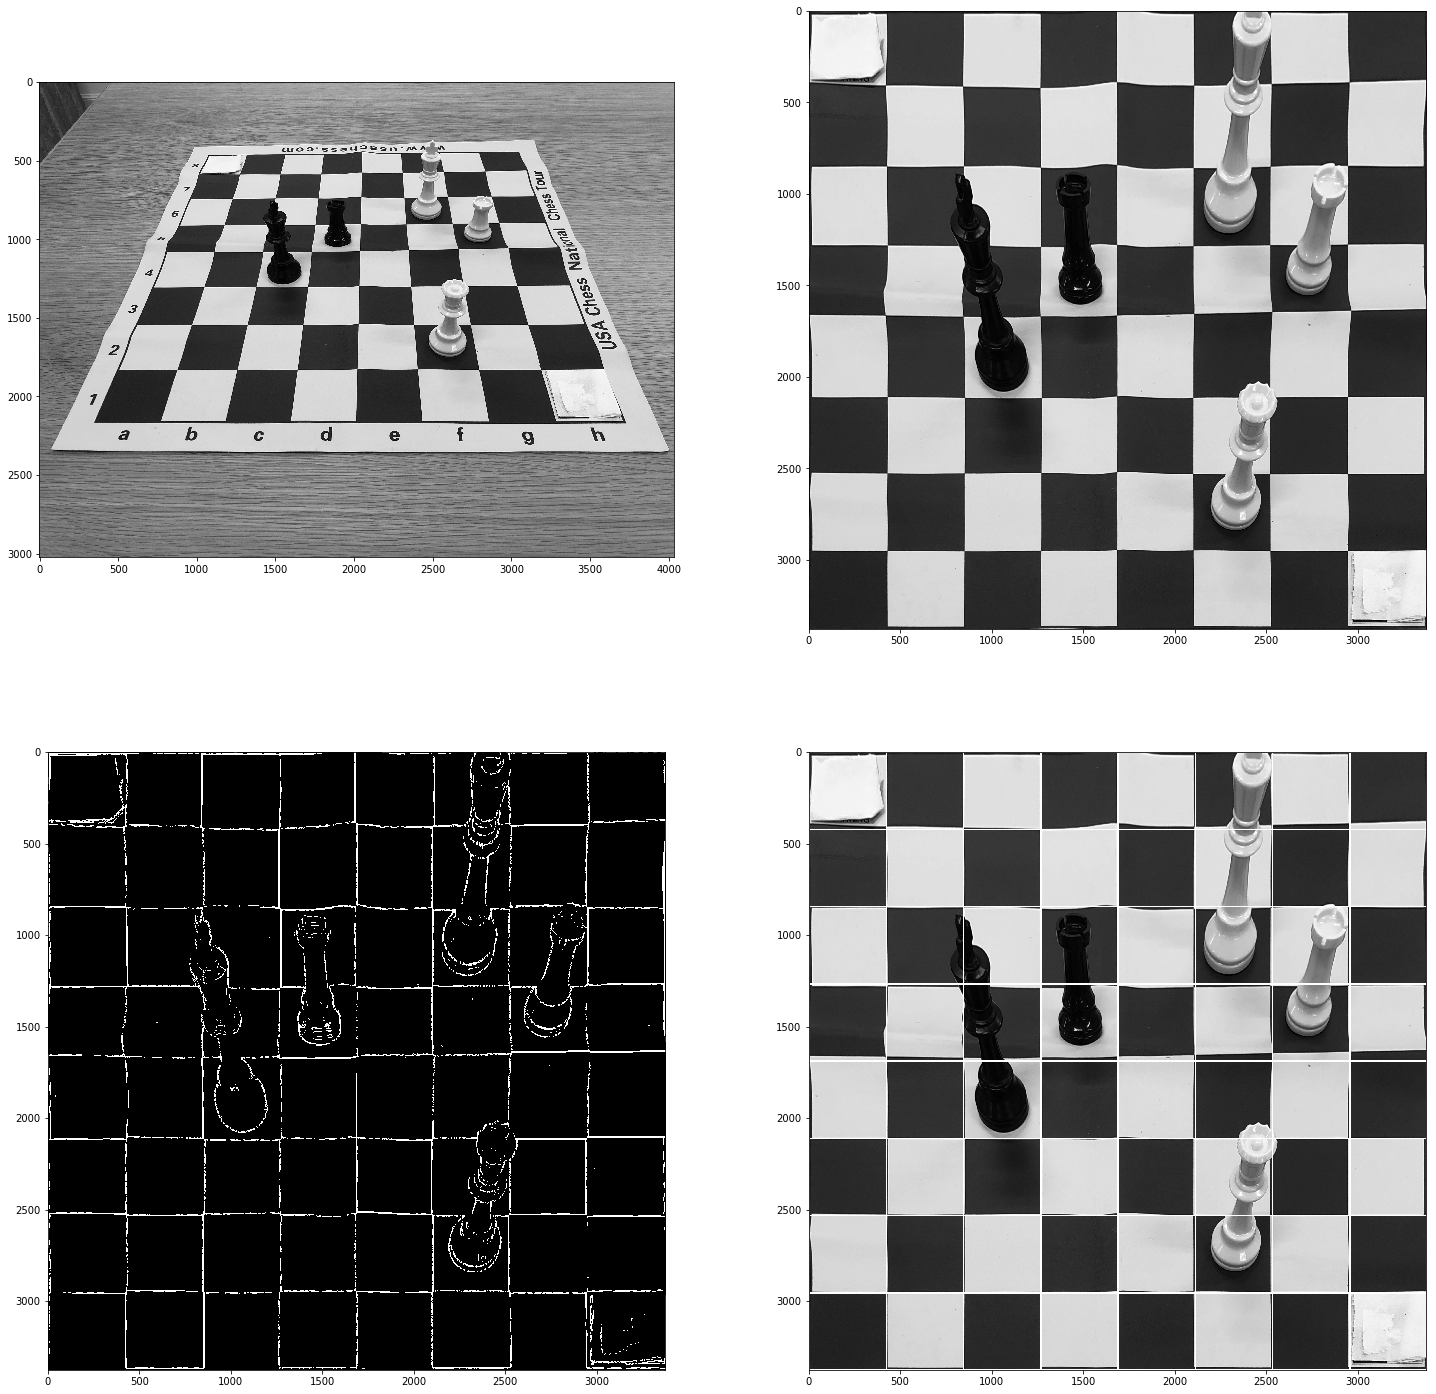

In [86]:
fig, ax = plt.subplots(2, 2,figsize=(25,25))


ax[0, 0].imshow(original, cmap='gray')
ax[0, 1].imshow(cropped, cmap='gray')
ax[1, 0].imshow(hough_lines_pic, cmap='gray')
ax[1, 1].imshow(grid_lines, cmap='gray')
plt.show()

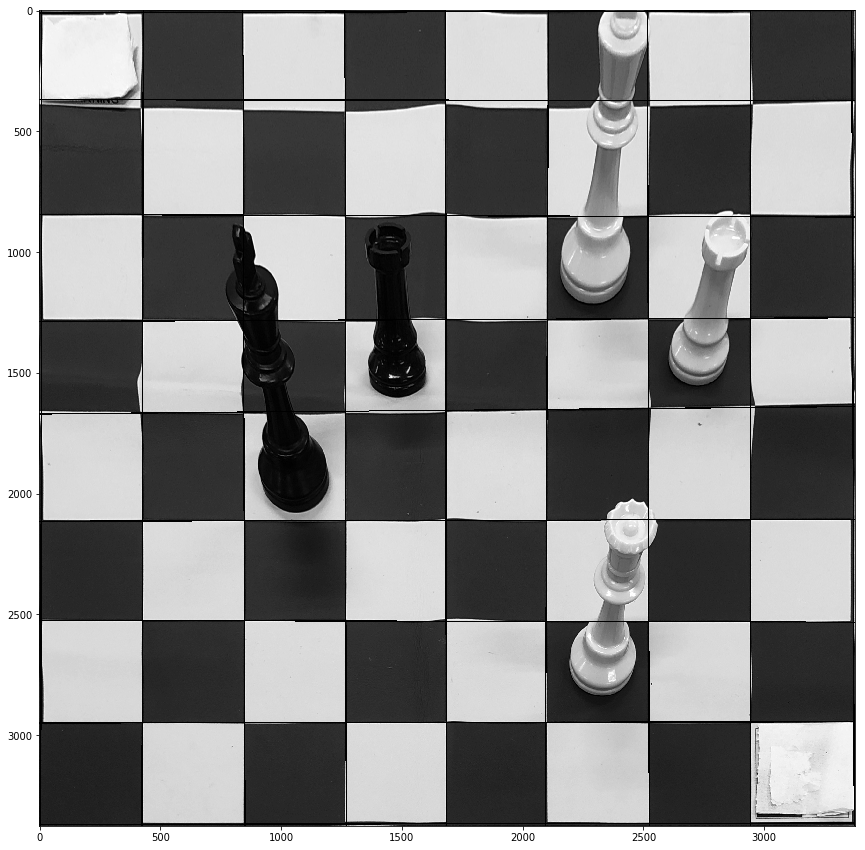

In [87]:
filtered_lines = filter_lines(hough_lines)
horizontal_lines, vertical_lines = split_horizontal_vertical(filtered_lines)
grid = build_grid(horizontal_lines, vertical_lines, cropped)

plt.figure(figsize=(15,15))
plt.imshow(plot_lines(grid, cropped.shape, cropped), cmap='gray')


In [88]:
#visualizing circles


# for intersection in intersections:
#     cv2.circle(cropped,intersection, 63, (0,0,255), -1)
# plt.figure(figsize=(15,15))
# plt.imshow(cropped, cmap='gray')

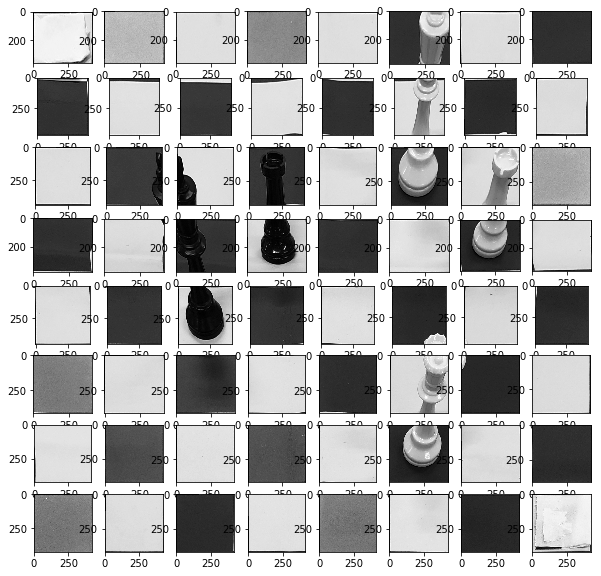

In [89]:
intersections = create_intersections(grid)
smart_squares = create_smart_squares(intersections)
plot_smart_squares(cropped, smart_squares)

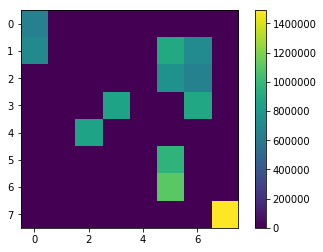

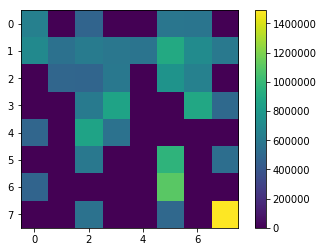

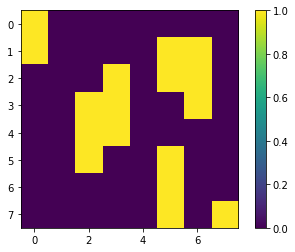

In [90]:
def heat_map(img, smart_squares):
    n = len(smart_squares[0])
    result = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            cropped = cut_from_rect(img, smart_squares[i][j])
            #_, lines_pic = create_lines(cropped)
            
            result[i,j]=np.sum(cv2.Canny(cropped,100,200))
            
    return result

hm = heat_map(cropped, smart_squares)
hm_hard = hm.copy()
hm_lite = hm.copy()
threshold = np.median(hm)

hm_hard[hm < 1.3 * threshold] = 0
hm_lite[hm<threshold] = 0

hm_result = np.zeros(hm.shape)

for i in range(8):
    for j in range(8):
        if hm_hard[i][j] > 0:
            hm_result[i][j] = 1
            if i-1 > 0 and hm_lite[i-1][j] > 0:
                hm_result[i-1][j] = 1
            if i+1 < 8 and hm_lite[i+1][j] > 0:
                hm_result[i+1][j] = 1
        

def heatmap2d(arr):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()
    
heatmap2d(hm_hard)
heatmap2d(hm_lite)
heatmap2d(hm_result)
    

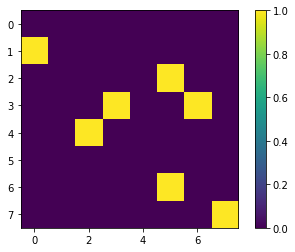

In [98]:
hm_r = np.zeros(hm_hard.shape)
for i in range(8):
    for j in range(7,-1,-1):
        if (i == 7 or hm_hard[i+1][j] == 0) and (hm_hard[i][j]>0):
            hm_r[i][j] = 1
heatmap2d(hm_r)

In [101]:
def convert_to_board(hm):
    board = [['.' for _ in range(8)] for _ in range(8)]
    for i in range(8):
        for j in range(7,-1,-1):
            if (i == 7 or hm_hard[i+1][j] == 0) and (hm_hard[i][j]>0):
                board[i][j] = 'p'
                
    return board
            

In [102]:
convert_to_board(hm_hard)

[['.', '.', '.', '.', '.', '.', '.', '.'],
 ['p', '.', '.', '.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.', 'p', '.', '.'],
 ['.', '.', '.', 'p', '.', '.', 'p', '.'],
 ['.', '.', 'p', '.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.', 'p', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '.', 'p']]

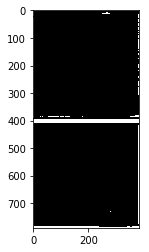

In [75]:
def reconstruct(img, *args):
    cropped_pics = []
    shapes = []
    for square in args:
        cropped_pic = cut_from_rect(img, square)
        cropped_pics.append(cropped_pic)
        shapes.append(cropped_pic.shape)
    shapes.sort(key= lambda x: x[0],reverse=True)
    target_shape_x = shapes[0][0]
    shapes.sort(key= lambda x: x[1],reverse=True)
    target_shape_y = shapes[0][1]
    for i, cropped_pic in enumerate(cropped_pics):
        cropped_pics[i] = np.pad(cropped_pic, ((target_shape_x-cropped_pic.shape[0],0),(target_shape_y-cropped_pic.shape[1],0)),'minimum')
    stacked = np.vstack(cropped_pics)
    return stacked

rook = reconstruct(cropped, smart_squares[6][3], smart_squares[7][3])
plt.imshow(pre_process_image(rook), cmap='gray')

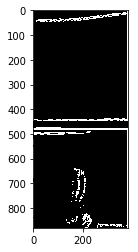

In [76]:
rook = reconstruct(cropped, smart_squares[1][3], smart_squares[2][3])
lines, lines_pic = create_lines(rook)
plt.imshow(lines_pic, cmap='gray')

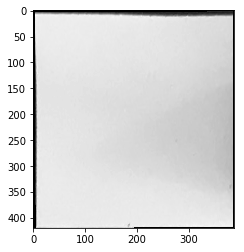

In [77]:
plt.imshow(cut_from_rect(cropped, smart_squares[4][2]), cmap='gray')

In [ ]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass



HIGH_VALUE = 10000
WIDTH = HIGH_VALUE
HEIGHT = HIGH_VALUE

DO_LIVE = False
if not DO_LIVE:
    raise StopExecution


cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
cap.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)


while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    processed = pre_process_image(gray)
    corners = find_corners_of_largest_polygon(processed)
    cropped = crop_and_warp(gray, corners)
#     squares = infer_grid(cropped)
#     grid_lines = embed_sqaures(cropped, squares)
#     hough_lines, hough_lines_pic = create_lines(cropped)
#     filtered_lines = filter_lines(hough_lines)
#     horizontal_lines, vertical_lines = split_horizontal_vertical(filtered_lines)
#     grid = build_grid(horizontal_lines, vertical_lines, cropped)

    # Display the resulting frame
    cv2.imshow('cropped',cropped)
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()